##  Transfer Learning Using Self-supervised Pretraining

- Flowers dataset https://www.kaggle.com/datasets/alxmamaev/flowers-recognition

In [56]:
!pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hamidrezahazaveh","key":"ffcaf69325684c112d615e2bafbc2e4f"}'}

In [57]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

In [58]:
!kaggle datasets download -d alxmamaev/flowers-recognition

Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
License(s): unknown
flowers-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [59]:
!unzip flowers-recognition.zip -d flowers

Archive:  flowers-recognition.zip
replace flowers/flowers/daisy/100080576_f52e8ee070_n.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: flowers/flowers/daisy/100080576_f52e8ee070_n.jpg  
replace flowers/flowers/daisy/10140303196_b88d3d6cec.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: flowers/flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/flowers/daisy/10437929963_bc13eebe0c

In [60]:
import os
os.listdir('flowers')

['flowers']

In [61]:
!pip install -q lightning-bolts

In [62]:
! pip install torchmetrics

We are implementing self-supervised pretraining using SWAV
on flower dataset

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
import pl_bolts
import torchvision
import torchmetrics
import pytorch_lightning as pl

from torch.optim import Adam
from torch.nn.functional import cross_entropy
from torchmetrics.functional import accuracy

from torchvision import models
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

from pytorch_lightning import Callback
from pytorch_lightning.loggers import CSVLogger

In [64]:
class FlowerDataModule(pl.LightningDataModule):
    def __init__(self, data_dir = 'flowers'):
        super().__init__()

        self.data_dir = data_dir
        self.transform = transforms.Compose(
          [
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p = 0.5),
            transforms.RandomVerticalFlip(p = 0.1),
            transforms.RandomRotation(10),
              transforms.ToTensor(),
              transforms.Normalize(
                  mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]
              ),
          ]
        )

    def setup(self, stage= None):
        flower_full = ImageFolder(self.data_dir, transform = self.transform)

        length = len(flower_full)

        val_split_size = 0.2

        train_length = round(length * (1 - val_split_size))
        val_length = length - train_length

        self.flower_train, self.flower_val = \
          random_split(flower_full , [train_length, val_length])

    def train_dataloader(self):
        train_dataloader = \
          DataLoader(self.flower_train, batch_size = 32, shuffle = True)

        return train_dataloader

    def val_dataloader(self):
        val_dataloader = \
          DataLoader(self.flower_val, batch_size = 32)

        return val_dataloader


In [65]:
flower_dm = FlowerDataModule()

flower_dm.setup()

## Self-Supervised Pretraining with SWAV
Pretrained SWAV model is loaded from specified weight path.Model is frozen for initial 10 epochs.Note that here we are unfreezing our backbone after 10 epochs.Also two feature maps are generated using SWAV model.We are taking only one of them.

https://pytorch-lightning-bolts.readthedocs.io/en/latest/self_supervised_models.html#swav.


In [66]:
from pl_bolts.models.self_supervised import SwAV

class FlowerImageClassifier(pl.LightningModule):
    def __init__(self, num_classes = 5, lr = 1e-3):
        super().__init__()
        self.save_hyperparameters()

        weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/swav_imagenet/swav_imagenet.pth.tar'
        swav = SwAV.load_from_checkpoint(weight_path, strict = True)

        self.backbone = swav.model
        self.finetune_layer = torch.nn.Linear(3000, num_classes)

    def training_step(self, batch, batch_idx):
        x, y = batch

        if self.trainer.current_epoch < 10:
            with torch.no_grad():
                  features = self.backbone(x)[-1]
        else:
            features = self.backbone(x)[-1]

        preds = self.finetune_layer(features)

        loss = cross_entropy(preds, y)
        accuracy_score = accuracy(preds, y, task='multiclass', num_classes=self.hparams.num_classes)

        metrics = {'train_loss': loss, 'train_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True,
                      prog_bar = True, logger = True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch

        features = self.backbone(x)[-1]
        preds = self.finetune_layer(features)

        loss = cross_entropy(preds, y)
        accuracy_score = accuracy(preds, y, task='multiclass', num_classes=self.hparams.num_classes)

        metrics = {'valid_loss': loss, 'valid_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True,
                      prog_bar = True, logger = True)

        return metrics

    def configure_optimizers(self):

        optimizer = Adam(self.parameters(), lr = self.hparams.lr)

        return optimizer

CSV Logger is defined to log the metrics into a csv file

In [67]:
logger = CSVLogger(save_dir = './lightning_logs', name = 'swav_bb_unfrozen')

Classifier is called and Trainer is defined and fit with Flower Datamodule.
Training is done for 20 epochs and logger is used for logging metrics

In [68]:
classifier = FlowerImageClassifier()

trainer = pl.Trainer(gpus = 1, max_epochs = 20, logger = logger)

trainer.fit(classifier, flower_dm)

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/migration/migration.py:195: PossibleUserWarning: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v0.9.1rc3 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file https:/pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/swav_imagenet/swav_imagenet.pth.tar`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [69]:
# classifier = FlowerImageClassifier()

# trainer = pl.Trainer(max_epochs = 20,
#                      limit_train_batches = 20,
#                      log_every_n_steps = 10, logger = logger, gpus = 1)

# trainer.fit(classifier, flower_dm)

Metrics logged in CSV file are now plotted.

In [70]:
trainer.logger.log_dir

'./lightning_logs/swav_bb_unfrozen/version_1'

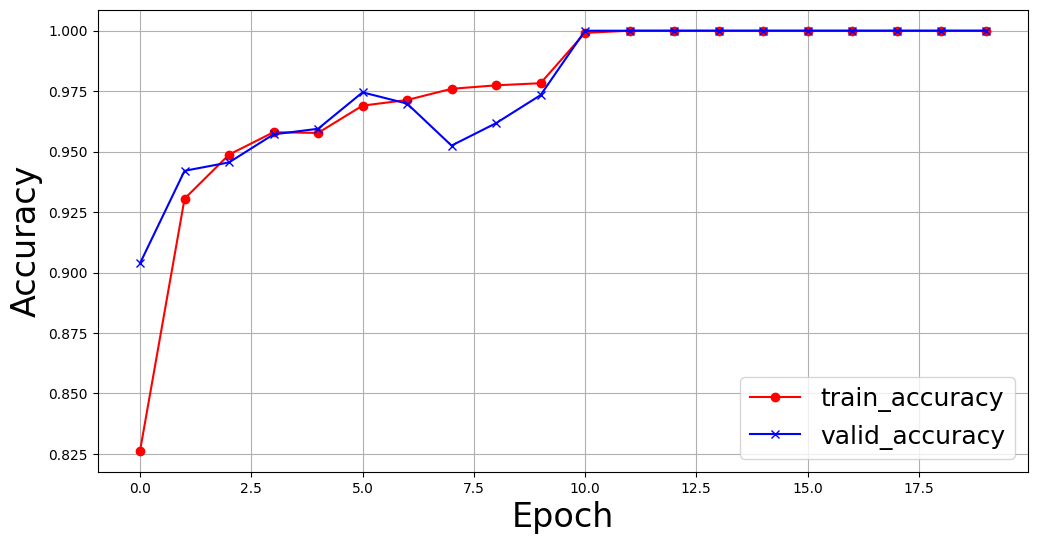

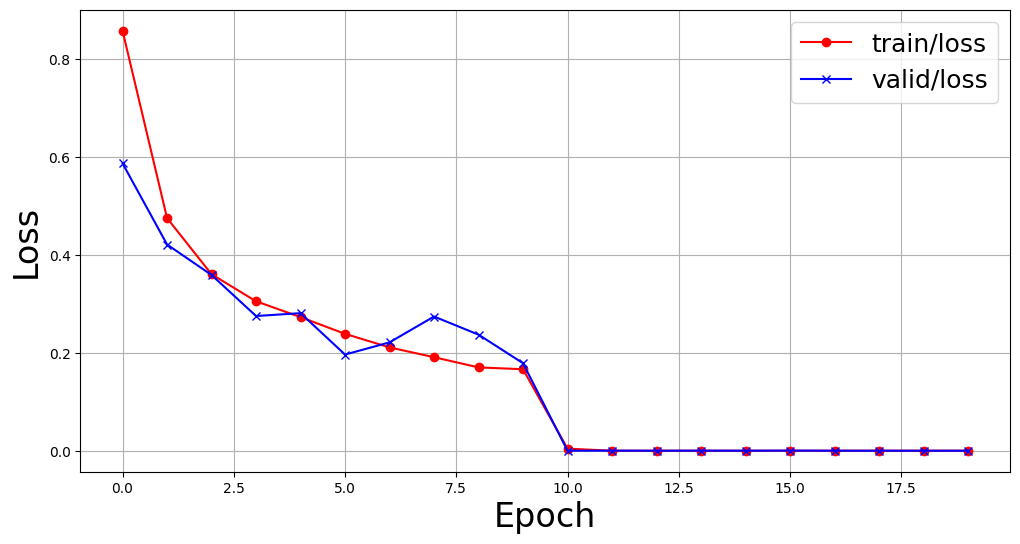

In [71]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
train_acc = metrics['train_acc'].dropna().reset_index(drop = True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)
valid_acc = metrics['valid_acc'].dropna().reset_index(drop = True)

fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_acc, color = 'r', marker = 'o', label = 'train_accuracy')
plt.plot(valid_acc, color = 'b', marker = 'x', label = 'valid_accuracy')

plt.ylabel('Accuracy', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'lower right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/acc_ssl_swav.png')

train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)

fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_loss, color = 'r', marker = 'o', label = 'train/loss')
plt.plot(valid_loss, color = 'b', marker = 'x', label = 'valid/loss')

plt.ylabel('Loss', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'upper right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/loss_ssl_swav.png')

Data augmentation specific to SWAV is applied by following method as train_transforms and val_transforms methods in datamodule are deprecatedLR is applied by following method as train_transforms and val_transforms methods in datamodule are deprecated

In [72]:
class ApplyTransform(Dataset):

    def __init__(self, dataset, transform = None):
        self.dataset = dataset
        self.transform = transform


    def __getitem__(self, idx):
        sample, target = self.dataset[idx]
        if self.transform is not None:
            sample = self.transform(sample)

        return sample, target

    def __len__(self):
        return len(self.dataset)

Transformations for both training and validation data specific to SIMCLR are defined. We have opted for stl10 normalisation. We can also remove normalisation if not needed.
Ref link-
https://pytorch-lightning-bolts.readthedocs.io/en/0.3.0/api/pl_bolts.models.self_supervised.swav.transforms.html#module-pl_bolts.models.self_supervised.swav.transforms

In [100]:
# Import necessary libraries
from torchvision import transforms

# Custom STL10 normalization transform (standard values)
def stl10_normalization_fn():
    return transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

# Using torchvision.transforms for train and validation (SwAV-like behavior)
train_transform_torchvision = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    stl10_normalization_fn()  # Custom normalization
])

val_transform_torchvision = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    stl10_normalization_fn()  # Custom normalization
])

# Using pl_bolts.transforms if SwAV is available
try:
    from pl_bolts.models.self_supervised.swav.transforms import (
        SwAVTrainDataTransform, SwAVEvalDataTransform
    )
    from pl_bolts.transforms.dataset_normalizations import stl10_normalization

    # Using SwAV Transformations if pl_bolts is installed and module is available
    train_transform_swav = SwAVTrainDataTransform(normalize=stl10_normalization())
    val_transform_swav = SwAVEvalDataTransform(normalize=stl10_normalization())

    print("SwAV transformations loaded successfully.")

except ModuleNotFoundError:
    print("SwAV transformations not found, using torchvision transforms instead.")

    # If SwAV transforms are not available, we fall back to the custom torchvision transformations
    train_transform_swav = train_transform_torchvision
    val_transform_swav = val_transform_torchvision

# Now, you can use either train_transform_swav and val_transform_swav (SwAV-style) or
# train_transform_torchvision and val_transform_torchvision (Custom torchvision-based)

# Example usage:
# train_loader = DataLoader(train_dataset, batch_size=32, transform=train_transform_swav)
# val_loader = DataLoader(val_dataset, batch_size=32, transform=val_transform_swav)





SwAV transformations not found, using torchvision transforms instead.


In [74]:
# from pl_bolts.models.self_supervised.swav.transforms import (
#     SwAVTrainDataTransform, SwAVEvalDataTransform
# )
# from pl_bolts.transforms.dataset_normalizations import stl10_normalization

# train_transform = SwAVTrainDataTransform(normalize = stl10_normalization())

# val_transform = SwAVEvalDataTransform(normalize = stl10_normalization())

Modified Datamodule is defined with transformations

In [112]:
# class FlowerDataModule(pl.LightningDataModule):
#     def __init__(self, train_transform, val_transform, data_dir = '/content/drive/MyDrive/flower/flowers'):
#         super().__init__()

#         self.data_dir = data_dir
#         self.transform = transforms.Compose([torchvision.transforms.Resize((224, 224))])

#         self.train_transform = train_transform
#         self.val_transform = val_transform

#     def setup(self, stage = None):
#         flower_full = ImageFolder(self.data_dir, transform = self.transform)

#         length = len(flower_full)

#         val_split_size = 0.2

#         train_length = round(length * (1 - val_split_size))
#         val_length = length - train_length

#         self.flower_train, self.flower_val = \
#             random_split(flower_full , [train_length, val_length])

#         self.flower_train = ApplyTransform(self.flower_train, transform = self.train_transform)
#         self.flower_val = ApplyTransform(self.flower_val, transform = self.val_transform)

#     def train_dataloader(self):
#         train_dataloader = \
#           DataLoader(self.flower_train, batch_size = 32, shuffle = True)

#         return train_dataloader

#     def val_dataloader(self):
#         val_dataloader = \
#           DataLoader(self.flower_val, batch_size = 32)

#         return val_dataloader

###############################
class ApplyTransform:
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        sample, target = self.dataset[idx]
        if self.transform:
            sample = self.transform(sample)  # Apply transform (which already includes ToTensor)
        return sample, target

    def __len__(self):
        return len(self.dataset)


class FlowerDataModule(pl.LightningDataModule):
    def __init__(self, train_transform, val_transform, data_dir='/content/flowers'):
        super().__init__()
        self.data_dir = data_dir
        self.train_transform = train_transform
        self.val_transform = val_transform

    def setup(self, stage=None):
        flower_full = ImageFolder(self.data_dir, transform=None)  # No transform initially

        length = len(flower_full)

        val_split_size = 0.2
        train_length = round(length * (1 - val_split_size))
        val_length = length - train_length

        self.flower_train, self.flower_val = random_split(flower_full, [train_length, val_length])

        # Apply the transformations only once
        self.flower_train = ApplyTransform(self.flower_train, transform=self.train_transform)
        self.flower_val = ApplyTransform(self.flower_val, transform=self.val_transform)

    def train_dataloader(self):
        return DataLoader(self.flower_train, batch_size=32, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.flower_val, batch_size=32)



Datamodule is instantiated and setup called

In [113]:
# flower_dm_swav = FlowerDataModule(train_transform , val_transform)

# flower_dm_swav.setup()

# Initialize FlowerDataModule with the correct path
flower_dm_swav = FlowerDataModule(train_transform=train_transform_swav, val_transform=val_transform_swav, data_dir='/content/flowers')

# Setup the data module
flower_dm_swav.setup()



Training dataloader is obtained and dimension is checked. Note that len(dataloader) gives no. of batches as Dataloader loads images in batch form.

In [114]:
train_dl = flower_dm_swav.train_dataloader()

len(train_dl)

108

Displaying augmented images with those transformations. Three sets of Images are formed. We are showing first set.

In [115]:
# def show_batch(dl):
#     for images, labels in dl:
#         fig, ax = plt.subplots(figsize = (12, 6))
#         ax.imshow(make_grid(images[0], nrow = 8).permute(1, 2, 0))
#         break

# show_batch(train_dl)

#######################
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        # images is a batch of images
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))  # Correcting this line to handle a batch of images
        ax.axis('off')  # Turn off axis for better visualization
        plt.show()
        break  # Show just one batch


Modified CLassifier Module with only one change where x=x[0]

In [122]:

# class FlowerImageClassifier(pl.LightningModule):
#     def __init__(self, num_classes = 5, lr = 1e-3):
#         super().__init__()
#         self.save_hyperparameters()

#         weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/swav_imagenet/swav_imagenet.pth.tar'
#         swav = SwAV.load_from_checkpoint(weight_path, strict = True)

#         self.backbone = swav.model
#         self.finetune_layer = torch.nn.Linear(3000, num_classes)

#     def training_step(self, batch, batch_idx):
#         x, y = batch
#         x = x[0]

#         if self.trainer.current_epoch < 10:
#             with torch.no_grad():
#                   features = self.backbone(x)[-1]
#         else:
#             features = self.backbone(x)[-1]

#         preds = self.finetune_layer(features)

#         loss = cross_entropy(preds, y)
#         accuracy_score = accuracy(preds, y)

#         metrics = {'train_loss': loss, 'train_acc': accuracy_score}
#         self.log_dict(metrics, on_step = False, on_epoch = True,
#                       prog_bar = True, logger = True)

#         return loss

#     def validation_step(self, batch, batch_idx):
#         x, y = batch
#         x = x[0]

#         features = self.backbone(x)[-1]
#         preds = self.finetune_layer(features)

#         loss = cross_entropy(preds, y)
#         accuracy_score = accuracy(preds, y)

#         metrics = {'valid_loss': loss, 'valid_acc': accuracy_score}
#         self.log_dict(metrics, on_step = False, on_epoch = True,
#                       prog_bar = True, logger = True)

#         return metrics

#     def configure_optimizers(self):

#         optimizer = Adam(self.parameters(), lr = self.hparams.lr)

#         return optimizer


import pytorch_lightning as pl
from torch.optim import Adam
from torch.nn.functional import cross_entropy
from torchmetrics.functional import accuracy
import torch

class FlowerImageClassifier(pl.LightningModule):
    def __init__(self, num_classes=5, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/swav_imagenet/swav_imagenet.pth.tar'
        swav = SwAV.load_from_checkpoint(weight_path, strict=True)
        self.backbone = swav.model
        self.finetune_layer = torch.nn.Linear(3000, num_classes)


    def training_step(self, batch, batch_idx):
      x, y = batch
      if self.trainer.current_epoch < 10:
          with torch.no_grad():
              features = self.backbone(x)[-1]
      else:
          features = self.backbone(x)[-1]

      preds = self.finetune_layer(features)

      loss = cross_entropy(preds, y)
      # Add 'task' and 'num_classes' to the accuracy calculation
      accuracy_score = accuracy(preds, y, task='multiclass', num_classes=self.hparams.num_classes)

      metrics = {'train_loss': loss, 'train_acc': accuracy_score}
      self.log_dict(metrics, on_step=False, on_epoch=True, prog_bar=True, logger=True)

      return loss


    def validation_step(self, batch, batch_idx):
      x, y = batch
      features = self.backbone(x)[-1]
      preds = self.finetune_layer(features)

      loss = cross_entropy(preds, y)
      accuracy_score = accuracy(preds, y, task='multiclass', num_classes=self.hparams.num_classes)

      metrics = {'valid_loss': loss, 'valid_acc': accuracy_score}
      self.log_dict(metrics, on_step=False, on_epoch=True, prog_bar=True, logger=True)

      return metrics


    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer

        return loss


Model is trained in the same way as earlier with logging.Note that after the model is unfrozen, there is a spike in loss and accuracy gets reduced.

In [123]:
logger = CSVLogger(save_dir = './lightning_logs', name = 'swav_bb_unfrozen_with_swavtransform')

In [124]:
classifier = FlowerImageClassifier()

trainer = pl.Trainer(max_epochs = 20,
                     limit_train_batches = 20,
                     log_every_n_steps = 10,
                     logger = logger, gpus = 1)

trainer.fit(classifier, flower_dm_swav)

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v0.9.1rc3 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file https:/pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/swav_imagenet/swav_imagenet.pth.tar`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type   | Params
------------------------------------------
0 | backbone       | ResNet | 28.4 M
1 | finetune_layer | Linear | 15.0 K
------------------------------------------
28.4 M 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


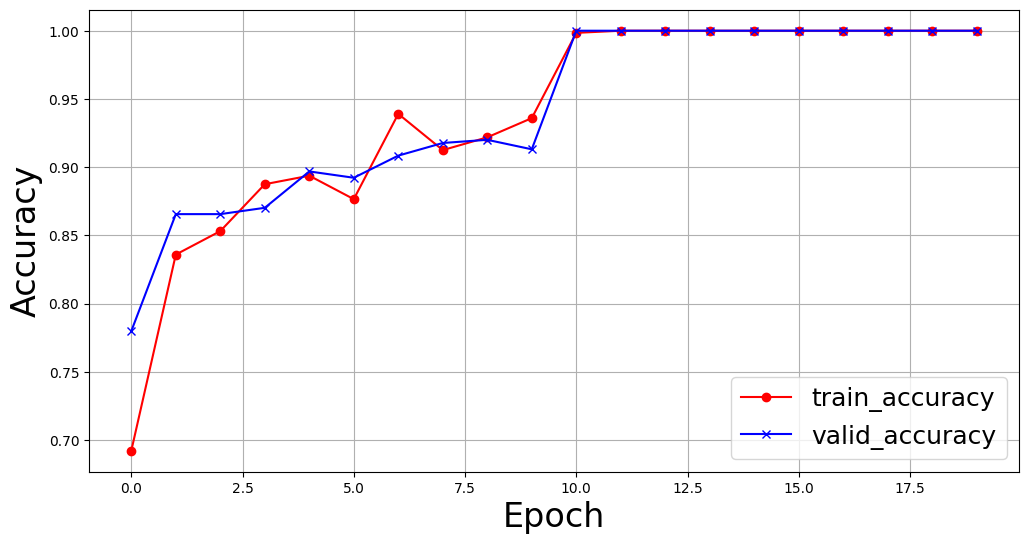

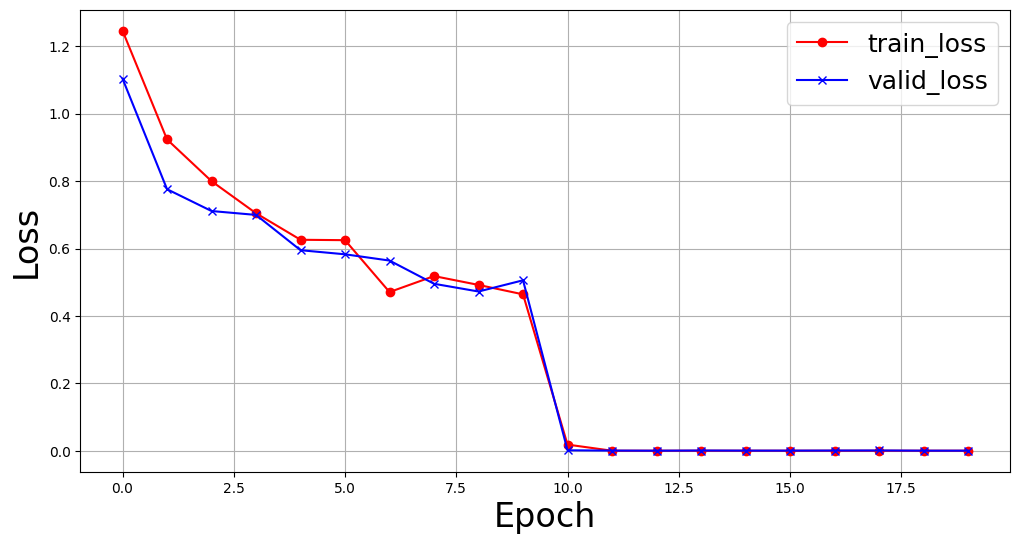

In [126]:
# metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

# train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
# train_acc = metrics['train_acc'].dropna().reset_index(drop = True)
# valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)
# valid_acc = metrics['valid_acc'].dropna().reset_index(drop = True)

# fig = plt.figure(figsize = (12, 6))
# plt.grid(True)

# plt.plot(train_acc, color = 'r', marker = 'o', label = 'train_accuracy')
# plt.plot(valid_acc, color = 'b', marker = 'x', label = 'valid_accuracy')

# plt.ylabel('Accuracy', fontsize = 24)
# plt.xlabel('Epoch', fontsize = 24)

# plt.legend(loc = 'lower right', fontsize = 18)
# plt.savefig(f'{trainer.logger.log_dir}/acc_ssl_swav_tr.png')

# train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
# valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)

# fig = plt.figure(figsize = (12, 6))
# plt.grid(True)

# plt.plot(train_loss, color = 'r', marker = 'o', label = 'train/loss')
# plt.plot(valid_loss, color = 'b', marker = 'x', label = 'valid/loss')

# plt.ylabel('Loss', fontsize = 24)
# plt.xlabel('Epoch', fontsize = 24)

# plt.legend(loc = 'upper right', fontsize = 18)
# plt.savefig(f'{trainer.logger.log_dir}/loss_ssl_swav_tr.png')\

######################################################
import pandas as pd
import matplotlib.pyplot as plt

# Load metrics from the CSV file
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

# Clean the data by dropping any NaN values and resetting the index
train_loss = metrics['train_loss'].dropna().reset_index(drop=True)
train_acc = metrics['train_acc'].dropna().reset_index(drop=True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop=True)
valid_acc = metrics['valid_acc'].dropna().reset_index(drop=True)

# Plot accuracy (train vs. validation)
fig = plt.figure(figsize=(12, 6))
plt.grid(True)

# Plot train and validation accuracy
plt.plot(train_acc, color='r', marker='o', label='train_accuracy')
plt.plot(valid_acc, color='b', marker='x', label='valid_accuracy')

# Set labels and legend
plt.ylabel('Accuracy', fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.legend(loc='lower right', fontsize=18)

# Save the accuracy plot
plt.savefig(f'{trainer.logger.log_dir}/acc_ssl_swav_tr.png')

# Plot loss (train vs. validation)
fig = plt.figure(figsize=(12, 6))
plt.grid(True)

# Plot train and validation loss
plt.plot(train_loss, color='r', marker='o', label='train_loss')
plt.plot(valid_loss, color='b', marker='x', label='valid_loss')

# Set labels and legend
plt.ylabel('Loss', fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.legend(loc='upper right', fontsize=18)

# Save the loss plot
plt.savefig(f'{trainer.logger.log_dir}/loss_ssl_swav_tr.png')


![](img/20201117-1-train_acc.svg "Train Accuracy")

![](img/20201117-1-train_loss.svg "Train Loss")